# Import library

In [112]:
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import statsmodels.api as sm

# Import dataset

In [113]:
 # EUR - VND
eur = pd.read_csv('EUR_VND.csv')
 # GBP - VND
gbp = pd.read_csv("GBP_VND.csv")
 # JPY - VND
jpy = pd.read_csv("JPY_VND.csv")
# Convert
eur = eur['Sale'].replace({',':''}, regex=True).astype(float)
gbp = gbp['Sale'].replace({',':''}, regex=True).astype(float)
jpy = jpy['Sale'].replace({',':''}, regex=True).astype(float)

# Split train, test

In [114]:
# Split train, test data
#### EUR - VND
  # case 1. 7:3
train_eur_1 = eur[:int(0.7*len(eur))]
test_eur_1 = eur[int(0.7*len(eur)):]
  # case 2. 8:2
train_eur_2 = eur[:int(0.8*len(eur))]
test_eur_2 = eur[int(0.8*len(eur)):]
  # case 3. 9:1
train_eur_3 = eur[:int(0.9*len(eur))]
test_eur_3 = eur[int(0.9*len(eur)):]
#### GBP - VND
  # case 1. 7:3
train_gbp_1 = gbp[:int(0.7*len(gbp))]
test_gbp_1 = gbp[int(0.7*len(gbp)):]
  # case 2. 8:2
train_gbp_2 = gbp[:int(0.8*len(gbp))]
test_gbp_2 = gbp[int(0.8*len(gbp)):]
  # case 3. 9:1
train_gbp_3 = gbp[:int(0.9*len(gbp))]
test_gbp_3 = gbp[int(0.9*len(gbp)):]
#### JPY - VND
  # case 1. 7:3
train_jpy_1 = jpy[:int(0.7*len(jpy))]
test_jpy_1 = jpy[int(0.7*len(jpy)):]
  # case 2. 8:2
train_jpy_2 = jpy[:int(0.8*len(jpy))]
test_jpy_2 = jpy[int(0.8*len(jpy)):]
  # case 3. 9:1
train_jpy_3 = jpy[:int(0.9*len(jpy))]
test_jpy_3 = jpy[int(0.9*len(jpy)):]

# Evaluate model

In [115]:
def accuracy(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    print('RMSE =',rmse)
    print('MAPE =',mape)
    print('MAE =',mae)

# ETS (Exponential Smoothing)

In [116]:
# Choose ETS model
trends = ['add', 'mul']
seasonals = ['add', 'mul']
def choose_ets_model(data):
    results = []
    for trend in trends:
        for seasonal in seasonals:
            try:
                model = sm.tsa.ExponentialSmoothing(data, trend=trend, seasonal=seasonal, seasonal_periods=12)
                # Fit the model
                fit_model = model.fit()

                results.append({
                    'Trend': trend,
                    'Seasonal': seasonal,
                    'AIC': fit_model.aic,
                    'BIC': fit_model.bic,
                    'Model': fit_model
                })
            except Exception as e:
                print(f"Failed to fit model with Trend: {trend}, Seasonal: {seasonal}")
    return results

# Find the best model based on AIC and BIC
results=choose_ets_model(eur)

for result in results:
    print(f"Trend: {result['Trend']}, Seasonal: {result['Seasonal']}, AIC: {result['AIC']:<10.4f},  BIC: {result['BIC']:<10.4f}")
if results:
    best_model_aic = min(results, key=lambda x: x['AIC'])
    best_model_bic = min(results, key=lambda x: x['BIC'])

    print("\nBest model based on AIC:")
    print(f"Trend: {best_model_aic['Trend']}, Seasonal: {best_model_aic['Seasonal']}, AIC: {best_model_aic['AIC']:<10.4f}")

    print("\nBest model based on BIC:")
    print(f"Trend: {best_model_bic['Trend']}, Seasonal: {best_model_bic['Seasonal']}, BIC: {best_model_bic['BIC']:<10.4f}")



C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Trend: add, Seasonal: add, AIC: 16975.6388,  BIC: 17063.7881
Trend: add, Seasonal: mul, AIC: 16976.7156,  BIC: 17064.8649
Trend: mul, Seasonal: add, AIC: 16976.0088,  BIC: 17064.1582
Trend: mul, Seasonal: mul, AIC: 16977.0858,  BIC: 17065.2352

Best model based on AIC:
Trend: add, Seasonal: add, AIC: 16975.6388

Best model based on BIC:
Trend: add, Seasonal: add, BIC: 17063.7881


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [117]:
# After choosing suitable model, define function to build
def build_model(data):
  model = ExponentialSmoothing(data,trend='add', seasonal='add', seasonal_periods=12).fit()
  return model

In [118]:
import matplotlib.pyplot as plt
import pandas as pd

def visualise_ETS_model(model, train, test, pre_test, f30, f60, f90):
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Training Data', color='blue')
    plt.plot(test.index, test, label='Actual Test Data', color='orange')
    plt.plot(test.index, pre_test, label='Prediction Test Data', color='green')
    
    f30_index = range(len(train) + len(test), len(train) + len(test) + len(f30))
    f60_index = range(len(train) + len(test) + len(f30), len(train) + len(test) + len(f30) + len(f60))
    f90_index = range(len(train) + len(test) + len(f30) + len(f60), len(train) + len(test) + len(f30) + len(f60) + len(f90))

    plt.plot(f30_index, f30, label='Forecast next 30 days', color='red')
    plt.plot(f60_index, f60, label='Forecast next 60 days', color='purple')
    plt.plot(f90_index, f90, label='Forecast next 90 days', color='pink')
    
    plt.title('ETS Time Series Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (VND)')
    plt.legend()
    plt.show()

In [119]:
def forecast_days(model, train, predicted_test):
    train_predicted = np.concatenate([train, predicted_test])
    
    # Forecase next 30 days
    model_30 = ExponentialSmoothing(train_predicted, trend='add', seasonal='add', seasonal_periods=12).fit()
    forecast30 = model_30.forecast(steps=30)
    train_predicted_30 = np.concatenate([train_predicted, forecast30])
    
    # Forecast the next 60 days
    model_60 = ExponentialSmoothing(train_predicted_30, trend='add', seasonal='add', seasonal_periods=12).fit()
    forecast60 = model_60.forecast(steps=30)
    train_predicted_60 = np.concatenate([train_predicted_30, forecast60])
    
    # Forecast the next 90 days
    model_90 = ExponentialSmoothing(train_predicted_60, trend='add', seasonal='add', seasonal_periods=12).fit()
    forecast90 = model_90.forecast(steps=30)
    
    return forecast30, forecast60, forecast90

# Define function predict next 30, 60, 90 days
def predict_data_ETS(model, train, test):
  pre_test= model.predict(start=len(train), end=len(train) + len(test) - 1)
  forecast30, forecast60, forecast90 = forecast_days(model, train, pre_test)
  return pre_test, forecast30, forecast60, forecast90

In [120]:
# Build model
model_eur_1 = build_model(train_eur_1)
model_eur_2 = build_model(train_eur_2)
model_eur_3 = build_model(train_eur_3)

model_jpy_1 = build_model(train_jpy_1)
model_jpy_2 = build_model(train_jpy_2)
model_jpy_3 = build_model(train_jpy_3)

model_gbp_1 = build_model(train_gbp_1)
model_gbp_2 = build_model(train_gbp_2)
model_gbp_3 = build_model(train_gbp_3)

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


**EUR_VND**

* Case 7:3

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


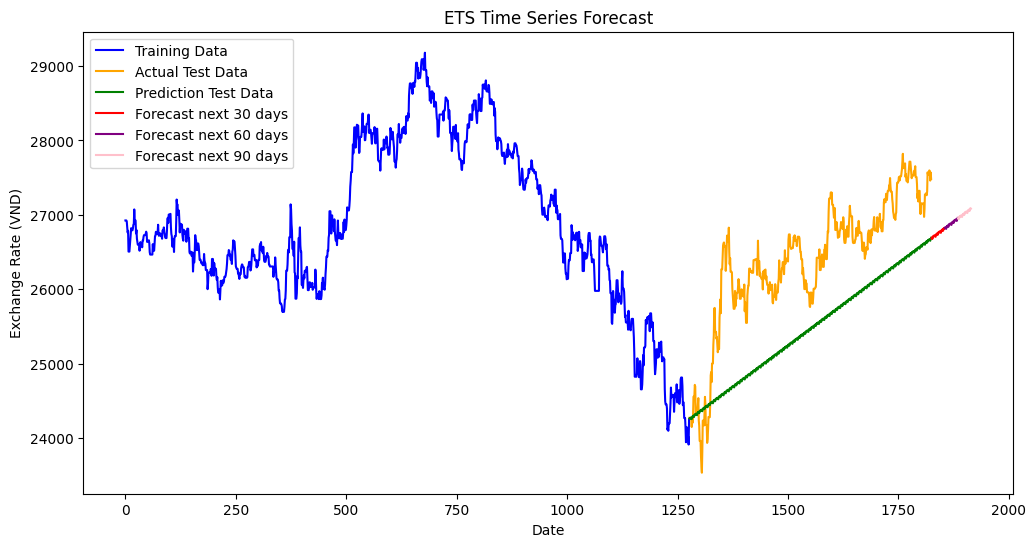

Model evaluation
RMSE = 1019.8579295068532
MAPE = 3.5319985507711547
MAE = 937.4118853183704


In [121]:
predict_test_eur_1, forecast_eur_1_30, forecast_eur_1_60, forecast_eur_1_90 = predict_data_ETS(model_eur_1, train_eur_1, test_eur_1)
visualise_ETS_model(model_eur_1,train_eur_1,test_eur_1,predict_test_eur_1,forecast_eur_1_30, forecast_eur_1_60, forecast_eur_1_90)

print('Model evaluation')
accuracy(predict_test_eur_1, test_eur_1)

* Case 8:2

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


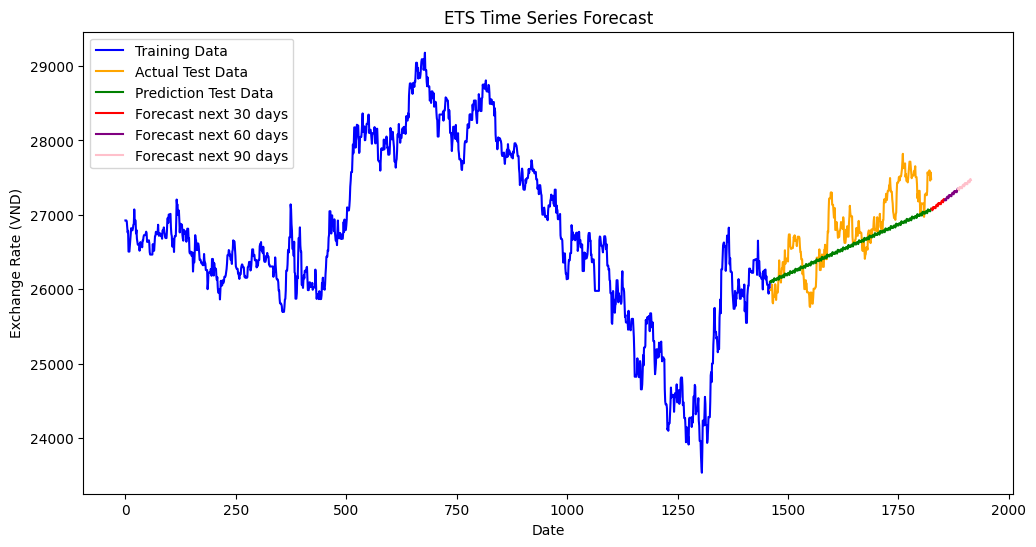

Model evaluation
RMSE = 367.35665265416225
MAPE = 1.1032902669543534
MAE = 297.67375700294923


In [122]:
predict_test_eur_2, forecast_eur_2_30, forecast_eur_2_60, forecast_eur_2_90 = predict_data_ETS(model_eur_2, train_eur_2, test_eur_2)
visualise_ETS_model(model_eur_2,train_eur_2,test_eur_2,predict_test_eur_2,forecast_eur_2_30, forecast_eur_2_60, forecast_eur_2_90)

print('Model evaluation')
accuracy(predict_test_eur_2, test_eur_2)

* Case 9:1

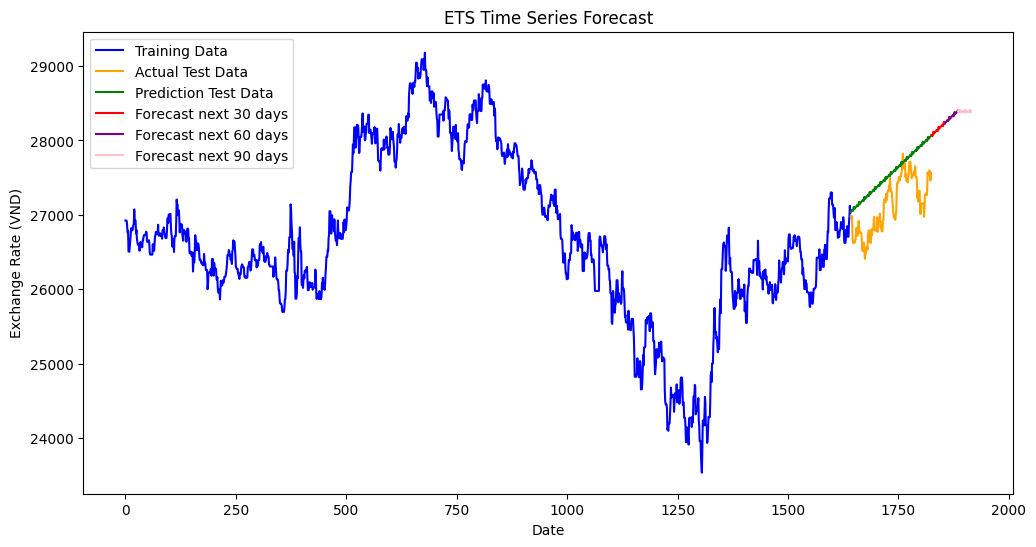

Model evaluation
RMSE = 486.21261457264984
MAPE = 1.602756510196313
MAE = 432.97006626415674


In [123]:
predict_test_eur_3, forecast_eur_3_30, forecast_eur_3_60, forecast_eur_3_90 = predict_data_ETS(model_eur_3, train_eur_3, test_eur_3)
visualise_ETS_model(model_eur_3,train_eur_3,test_eur_3,predict_test_eur_3,forecast_eur_3_30, forecast_eur_3_60, forecast_eur_3_90)

print('Model evaluation')
accuracy(predict_test_eur_3, test_eur_3)

**JPY_VND**

* Case 7:3

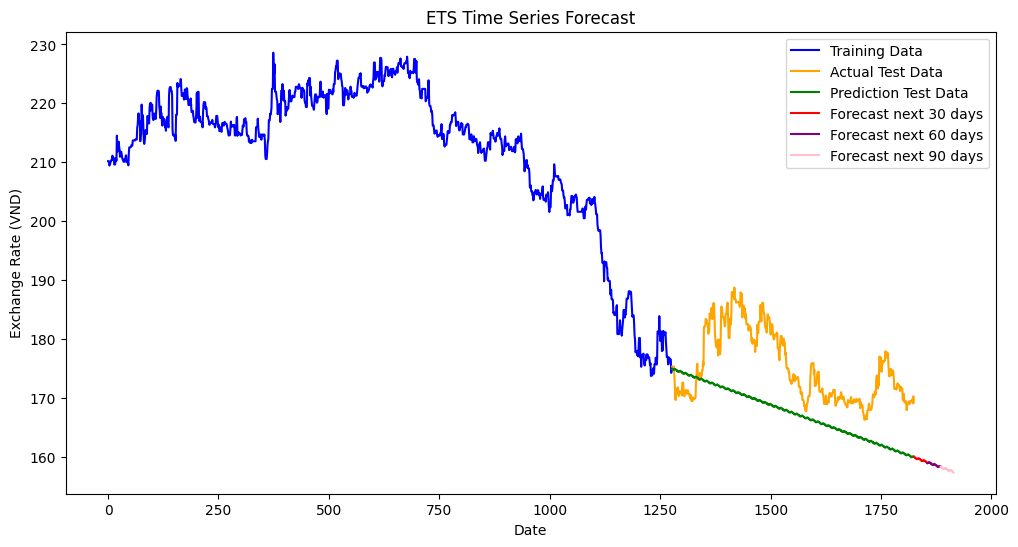

Model evaluation
RMSE = 9.371130374647956
MAPE = 4.6981495474642925
MAE = 8.326801902097474


In [124]:
predict_test_jpy_1, forecast_jpy_1_30, forecast_jpy_1_60, forecast_jpy_1_90 = predict_data_ETS(model_jpy_1, train_jpy_1, test_jpy_1)
visualise_ETS_model(model_jpy_1,train_jpy_1,test_jpy_1,predict_test_jpy_1,forecast_jpy_1_30, forecast_jpy_1_60, forecast_jpy_1_90)

print('Model evaluation')
accuracy(predict_test_jpy_1, test_jpy_1)

* Case 8:2

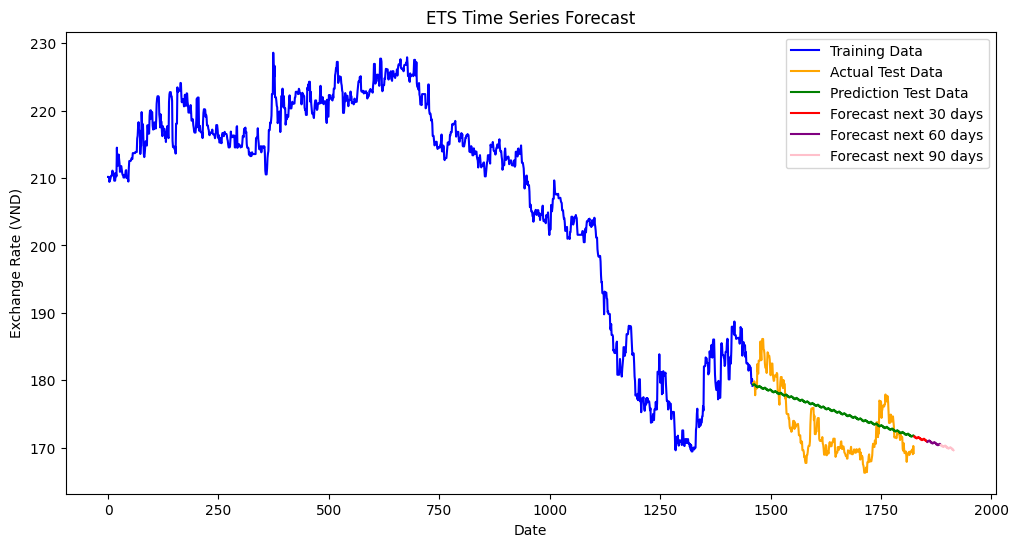

Model evaluation
RMSE = 4.4136531322428425
MAPE = 2.25279038320274
MAE = 3.876475710613472


In [125]:
predict_test_jpy_2, forecast_jpy_2_30, forecast_jpy_2_60, forecast_jpy_2_90 = predict_data_ETS(model_jpy_2, train_jpy_2, test_jpy_2)
visualise_ETS_model(model_jpy_2,train_jpy_2,test_jpy_2,predict_test_jpy_2,forecast_jpy_2_30, forecast_jpy_2_60, forecast_jpy_2_90)

print('Model evaluation')
accuracy(predict_test_jpy_2, test_jpy_2)

* Case 9:1

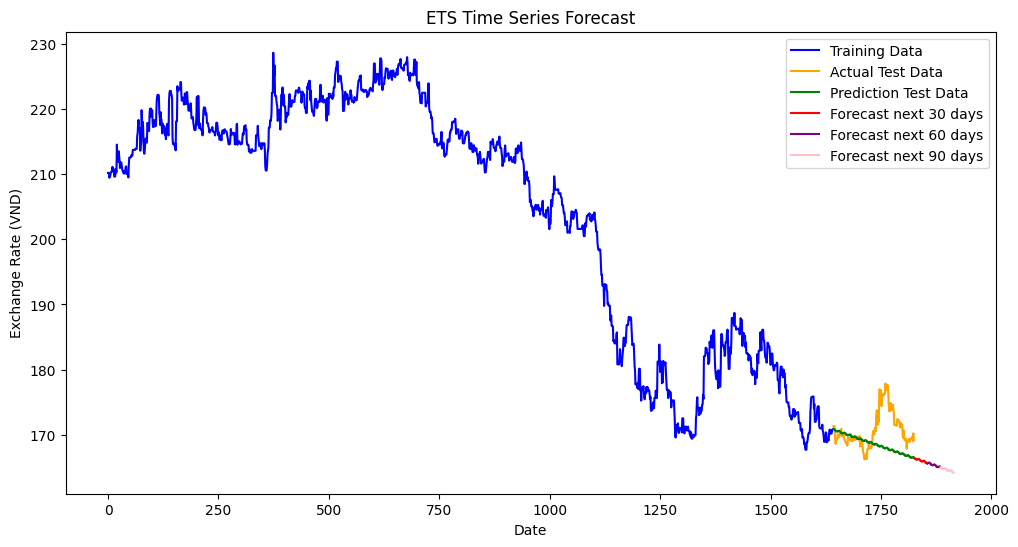

Model evaluation
RMSE = 3.988706614685761
MAPE = 1.688247834344751
MAE = 2.9201585687948737


In [126]:
predict_test_jpy_3, forecast_jpy_3_30, forecast_jpy_3_60, forecast_jpy_3_90 = predict_data_ETS(model_jpy_3, train_jpy_3, test_jpy_3)
visualise_ETS_model(model_jpy_3,train_jpy_3,test_jpy_3,predict_test_jpy_3,forecast_jpy_3_30, forecast_jpy_3_60, forecast_jpy_3_90)

print('Model evaluation')
accuracy(predict_test_jpy_3, test_jpy_3)

**GBP_VND**

* Case 7:3

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


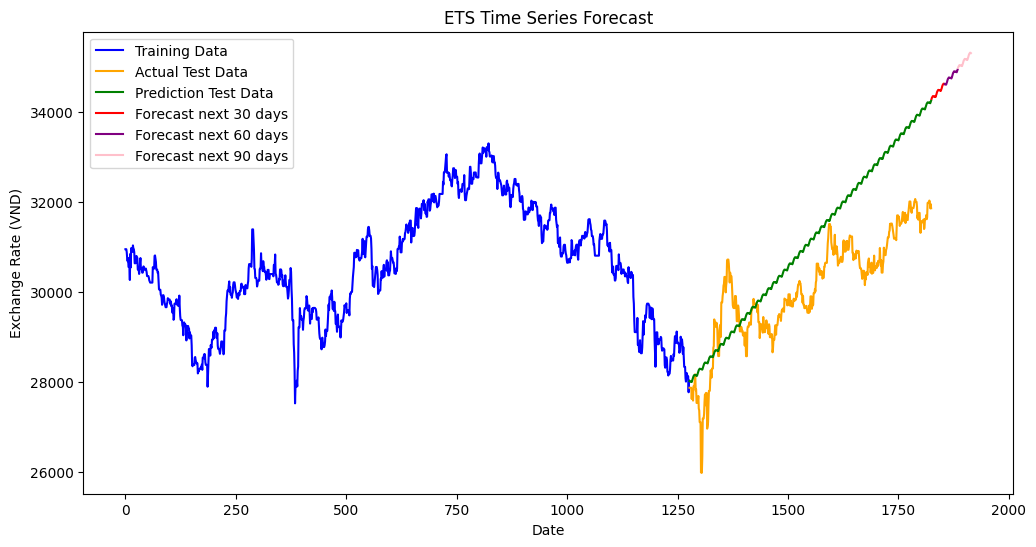

Model evaluation
RMSE = 1403.0733389014283
MAPE = 3.9874594081579313
MAE = 1213.5244469682148


In [127]:
predict_test_gbp_1, forecast_gbp_1_30, forecast_gbp_1_60, forecast_gbp_1_90 = predict_data_ETS(model_gbp_1, train_gbp_1, test_gbp_1)
visualise_ETS_model(model_gbp_1,train_gbp_1,test_gbp_1,predict_test_gbp_1,forecast_gbp_1_30, forecast_gbp_1_60, forecast_gbp_1_90)

print('Model evaluation')
accuracy(predict_test_gbp_1, test_gbp_1)

* Case 8:2

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


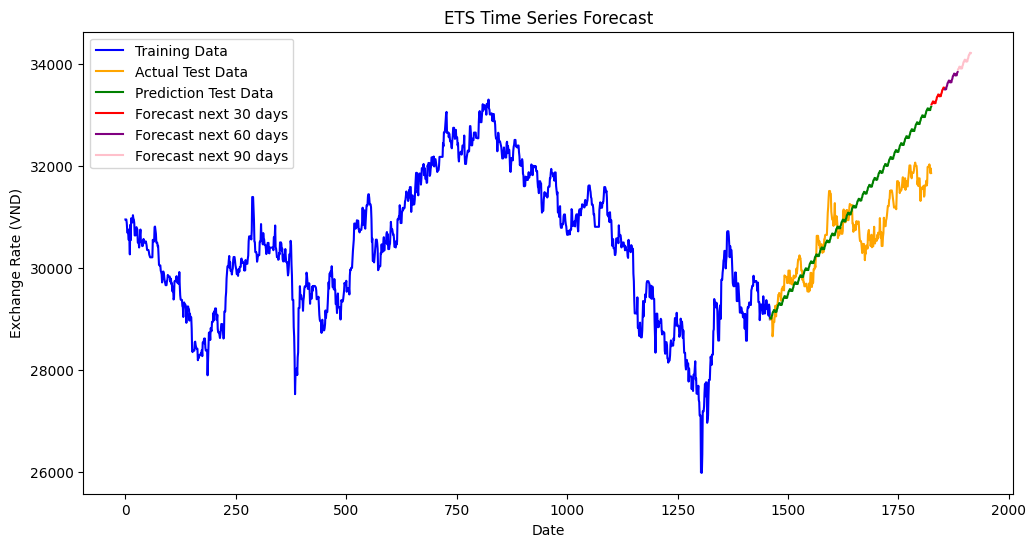

Model evaluation
RMSE = 741.0959638291981
MAPE = 1.9274641926495133
MAE = 597.0690007396618


In [128]:
predict_test_gbp_2, forecast_gbp_2_30, forecast_gbp_2_60, forecast_gbp_2_90 = predict_data_ETS(model_gbp_2, train_gbp_2, test_gbp_2)
visualise_ETS_model(model_gbp_2,train_gbp_2,test_gbp_2,predict_test_gbp_2,forecast_gbp_2_30, forecast_gbp_2_60, forecast_gbp_2_90)

print('Model evaluation')
accuracy(predict_test_gbp_2, test_gbp_2)

* Case 9:1

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


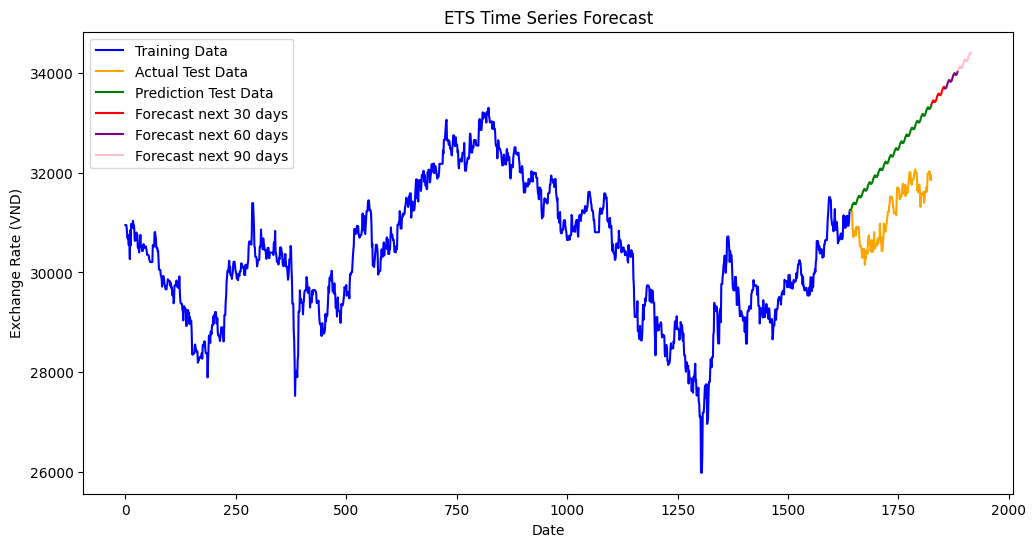

Model evaluation
RMSE = 1173.279282154701
MAPE = 3.6140864314036523
MAE = 1126.354751917966


In [129]:
predict_test_gbp_3, forecast_gbp_3_30, forecast_gbp_3_60, forecast_gbp_3_90 = predict_data_ETS(model_gbp_3, train_gbp_3, test_gbp_3)
visualise_ETS_model(model_gbp_3,train_gbp_3,test_gbp_3,predict_test_gbp_3,forecast_gbp_3_30, forecast_gbp_3_60, forecast_gbp_3_90)

print('Model evaluation')
accuracy(predict_test_gbp_3, test_gbp_3)